In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F


spark = SparkSession.builder.appName("data_serving_LinearRegression").getOrCreate()

df = spark.read.parquet("hdfs:///project/cleaned_data_parquet")

df.show()


+----------+-----------+--------+--------+
|      date|temperature|feature1|feature2|
+----------+-----------+--------+--------+
|2000-01-01|         -6|    0.02|     1.0|
|2000-01-02|         -1|    0.03|     1.0|
|2000-01-03|          2|    0.05|     1.0|
|2000-01-04|          2|    0.07|     1.0|
|2000-01-05|         -1|    0.09|     1.0|
|2000-01-06|          5|     0.1|    0.99|
|2000-01-07|          4|    0.12|    0.99|
|2000-01-08|          6|    0.14|    0.99|
|2000-01-09|          1|    0.15|    0.99|
|2000-01-10|          0|    0.17|    0.99|
|2000-01-11|          3|    0.19|    0.98|
|2000-01-12|          2|    0.21|    0.98|
|2000-01-13|          1|    0.22|    0.98|
|2000-01-14|         -2|    0.24|    0.97|
|2000-01-15|         -3|    0.26|    0.97|
|2000-01-16|          0|    0.27|    0.96|
|2000-01-17|          8|    0.29|    0.96|
|2000-01-18|          3|     0.3|    0.95|
|2000-01-19|          1|    0.32|    0.95|
|2000-01-20|          4|    0.34|    0.94|
+----------

In [ ]:
total_count = df.count()

train_size = int(total_count * 0.8)
test_size = int(total_count - train_size)

train_df = df.limit(train_size).orderBy(F.col("date"))
test_df = df.subtract(train_df).orderBy(F.col("date"))

train_df.show()

print("train size: ", train_df.count())
print("test size: ", test_df.count())

print(test_df.first())

+----------+-----------+--------+--------+
|      date|temperature|feature1|feature2|
+----------+-----------+--------+--------+
|2000-01-01|         -6|    0.02|     1.0|
|2000-01-02|         -1|    0.03|     1.0|
|2000-01-03|          2|    0.05|     1.0|
|2000-01-04|          2|    0.07|     1.0|
|2000-01-05|         -1|    0.09|     1.0|
|2000-01-06|          5|     0.1|    0.99|
|2000-01-07|          4|    0.12|    0.99|
|2000-01-08|          6|    0.14|    0.99|
|2000-01-09|          1|    0.15|    0.99|
|2000-01-10|          0|    0.17|    0.99|
|2000-01-11|          3|    0.19|    0.98|
|2000-01-12|          2|    0.21|    0.98|
|2000-01-13|          1|    0.22|    0.98|
|2000-01-14|         -2|    0.24|    0.97|
|2000-01-15|         -3|    0.26|    0.97|
|2000-01-16|          0|    0.27|    0.96|
|2000-01-17|          8|    0.29|    0.96|
|2000-01-18|          3|     0.3|    0.95|
|2000-01-19|          1|    0.32|    0.95|
|2000-01-20|          4|    0.34|    0.94|
+----------

## Linear Regression 

In [10]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

assembler = VectorAssembler(inputCols=["feature1", "feature2"], outputCol="features")
train_input = assembler.transform(train_df)
test_input = assembler.transform(test_df)

#Create LR model3
lr = LinearRegression(featuresCol="features", labelCol="temperature")
lr_model = lr.fit(train_input)

print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

#Predict
predictions = lr_model.transform(test_input)
predictions.select("prediction", "temperature", "features").show()

# Evaluate the model using RMSE, MSE, and MAE   
evaluator = RegressionEvaluator(labelCol='temperature', predictionCol='prediction')

Coefficients: [-2.9892225574955167,-9.749257714326449]
Intercept: 6.88744322555351
+------------------+-----------+--------------------+
|        prediction|temperature|            features|
+------------------+-----------+--------------------+
|10.443112489126172|          5|[0.80000001192092...|
|10.570497170360778|          1|[0.79000002145767...|
|10.727774226834438|          3|[0.76999998092651...|
|10.952651392236138|          5|[0.75999999046325...|
|11.080036654571789|          7|[0.75,-0.66000002...|
|11.207421335806394|          8|[0.74000000953674...|
|11.334806017040997|          8|[0.73000001907348...|
|  11.5596831824427|          7|[0.72000002861022...|
|11.687068041848853|         10|[0.70999997854232...|
| 11.84434550125201|         12|[0.68999999761581...|
|11.971730182486613|         14|[0.68000000715255...|
| 12.09911486372122|         15|[0.67000001668930...|
|12.323992029122923|         13|[0.66000002622604...|
|12.481269085596583|         12|[0.63999998569488...|

# TODO Add markdown

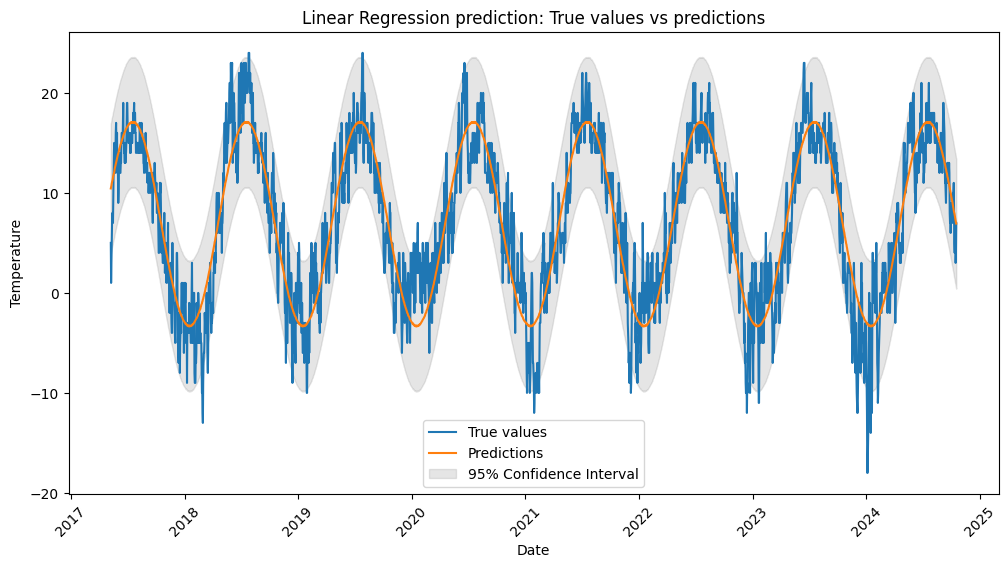

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
mse = evaluator.evaluate(predictions, {evaluator.metricName: "mse"})
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})

margin_of_error = 1

dates = test_df.select("date").collect()
actual = np.array([row[0] for row in test_df.select("temperature").collect()])

# Got from openAi by asking to plot the dates in x-axis and giving the date format to the model
dates = [datetime.strptime(date[0], '%Y-%m-%d') for date in dates]

predictions = np.array([row[0] for row in predictions.select("prediction").collect()])
# Calculate residuals
residuals = actual - predictions
    
# Calculate standard deviation of residuals
std_residuals = np.std(residuals)

# Calculate prediction intervals
z_score = 1.96  # For 95% confidence interval
prediction_intervals = z_score * std_residuals

# Calculate confidence intervals
lower_bounds = predictions - prediction_intervals
upper_bounds = predictions + prediction_intervals

# Check if true values lie within confidence intervals
within_confidence_interval = np.logical_and(
    actual >= lower_bounds,
    actual <= upper_bounds
)

# Calculate the percentage of true values within the confidence intervals
percentage_within_interval = np.mean(within_confidence_interval) * 100

# Calculate the absolute differences between predictions and true values
absolute_differences = np.abs(actual - predictions)

# Check if the absolute differences are within the margin of error
within_margin_of_error = absolute_differences <= margin_of_error

# Calculate the percentage of predictions within the margin of error
percentage_within_margin = np.mean(within_margin_of_error) * 100
    
# Plot true values, predictions, and confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(dates, actual, label="True values")
plt.plot(dates, predictions, label="Predictions")
plt.fill_between(dates, lower_bounds, upper_bounds, color='gray', alpha=0.2, label="95% Confidence Interval")
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title(f"Linear Regression prediction: True values vs predictions")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
print(f"Linear Regression MAE: {mae}")
print(f"Linear Regression RMSE: {rmse}")
print(f"Linear Regression MSE: {mse}")
print(f"percentage within confidence interval: {percentage_within_interval}%")
print(f"Percentage within margin of error: {percentage_within_margin}%")

Linear Regression MAE: 2.616418599524208
Linear Regression RMSE: 3.32033457629992
Linear Regression MSE: 11.02462169857277
percentage within confidence interval: 94.88217967599411%
Percentage within margin of error: 23.969072164948454%


In [ ]:
spark.stop()